# Working with Domain-Specific Data

In this notebook we'll look at working with domain-specific unstructred data&mdash;images, text, etc.

In [1]:
%matplotlib inline

import math
import warnings

import joblib
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import (Bidirectional, Conv2D, Dense, Embedding, Flatten, GlobalAveragePooling1D,
                          Input, LSTM, MaxPooling2D, Reshape)
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from mlxtend.plotting import plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, auc, classification_report, confusion_matrix,
                             mean_squared_error, precision_recall_curve, roc_curve)
from sklearn.model_selection import KFold, learning_curve, ShuffleSplit, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

#warnings.filterwarnings('ignore')

# Image Classification

## Load the MNIST Dataset

Dataset of 28x28 pixel images of handwritten digits. From https://www.kaggle.com/c/digit-recognizer.

In [2]:
df_img_train = pd.read_csv('../data/digit-recognizer/train.csv')
df_img_test = pd.read_csv('../data/digit-recognizer/test.csv')

In [3]:
df_img_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df_img_train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [5]:
sorted(df_img_train['label'].unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [6]:
df_img_train['label'].value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

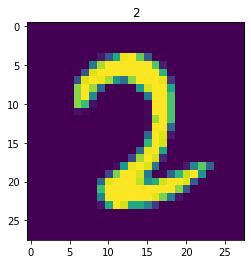

In [7]:
num = int(np.random.rand() * (len(df_img_train)))
plt.imshow(df_img_train.iloc[:, 1:].iloc[num].values.reshape(28, 28))
y_ = df_img_train['label'].iloc[num]
plt.title(y_)
plt.show()

## Data Preprocessing

Identify and extract feature columns. Extract label column and convert it to categorical values.

In [8]:
X_img = df_img_train.iloc[:, 1:]
y_img = df_img_train.label

In [9]:
y_img_cat = to_categorical(y_img)
y_img_cat

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

## Model Building

Build image classification models. Here we build two artificial neural networks.

We will start by building a simple, dense (fully connected) neural network (DNN).

In [10]:
inputs = Input(shape=(784,))
x = Dense(256, activation='relu')(inputs)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)

model_img_dnn = Model(inputs=inputs, outputs=outputs)
model_img_dnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_img_dnn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 242,762
Trainable params: 242,762
Non-trainable params: 0
_________________________________________________________________


Next, we will build a convolutional neural network (CNN).

In [11]:
inputs = Input(shape=(784,))
x = Reshape((28, 28, 1))(inputs)
                         
x = Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=128, kernel_size=(3,3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)

model_img_cnn = Model(inputs=inputs, outputs=outputs)
model_img_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_img_cnn.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         7385

Notice that the CNN has fewer trainable parameters than the DNN.

## Model Training

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X_img, y_img_cat, test_size=0.2, random_state=0)

In [13]:
history_img_dnn = model_img_dnn.fit(X_train, y_train, epochs=5, verbose=2, validation_data=(X_valid, y_valid));

Epoch 1/5
1050/1050 - 11s - loss: 1.6381 - accuracy: 0.8503 - val_loss: 0.3569 - val_accuracy: 0.9108
Epoch 2/5
1050/1050 - 2s - loss: 0.3033 - accuracy: 0.9244 - val_loss: 0.3333 - val_accuracy: 0.9248
Epoch 3/5
1050/1050 - 2s - loss: 0.2307 - accuracy: 0.9407 - val_loss: 0.2685 - val_accuracy: 0.9325
Epoch 4/5
1050/1050 - 2s - loss: 0.1779 - accuracy: 0.9501 - val_loss: 0.2645 - val_accuracy: 0.9364
Epoch 5/5
1050/1050 - 2s - loss: 0.1682 - accuracy: 0.9537 - val_loss: 0.2249 - val_accuracy: 0.9444


In [14]:
history_img_cnn = model_img_cnn.fit(X_train, y_train, epochs=5, verbose=2, validation_data=(X_valid, y_valid));

Epoch 1/5
1050/1050 - 20s - loss: 0.3762 - accuracy: 0.9115 - val_loss: 0.1451 - val_accuracy: 0.9604
Epoch 2/5
1050/1050 - 25s - loss: 0.1046 - accuracy: 0.9687 - val_loss: 0.0873 - val_accuracy: 0.9746
Epoch 3/5
1050/1050 - 26s - loss: 0.0789 - accuracy: 0.9762 - val_loss: 0.0844 - val_accuracy: 0.9764
Epoch 4/5
1050/1050 - 27s - loss: 0.0683 - accuracy: 0.9788 - val_loss: 0.1092 - val_accuracy: 0.9710
Epoch 5/5
1050/1050 - 27s - loss: 0.0575 - accuracy: 0.9829 - val_loss: 0.0677 - val_accuracy: 0.9806


## Model Evaluation

The models produce 10 outputs, one for each digit. Each output ranges from 0 to 1. We can consider the digit with the largest output value as the prediction.

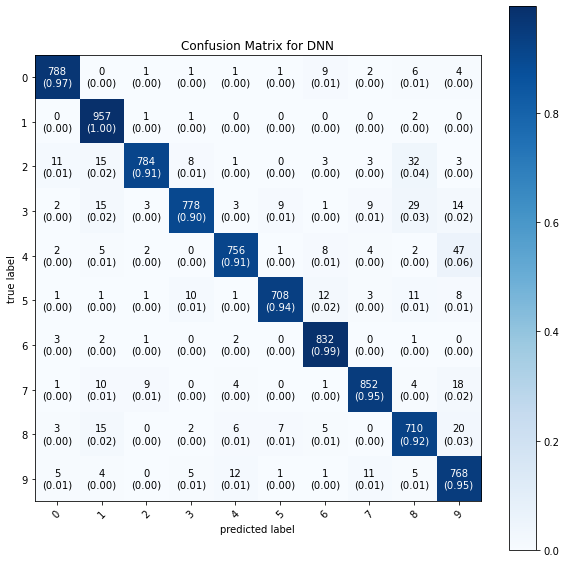

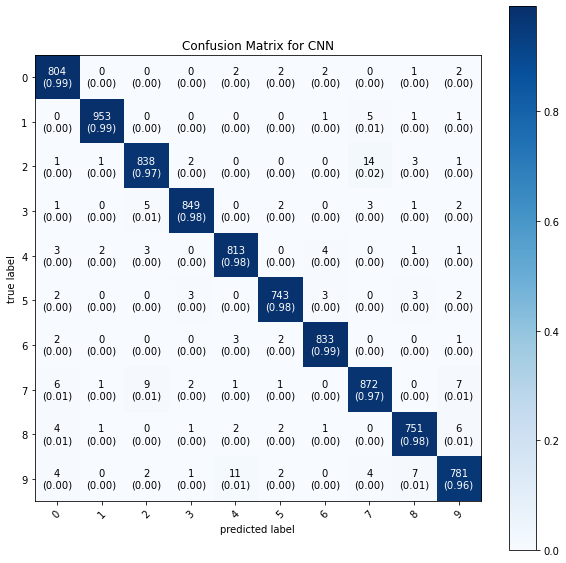

In [15]:
for model_name, model in {'DNN': model_img_dnn, 'CNN': model_img_cnn}.items():
    y_pred = np.argmax(model.predict(X_valid), axis=1)
    y_test = np.argmax(y_valid, axis=1)

    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plot_confusion_matrix(
        conf_mat=cm,
        figsize=(10, 10),
        colorbar=True,
        show_absolute=True,
        show_normed=True,
        class_names=np.arange(10)
    )
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

## Predict on New Data

For each test instance, predicted the digit with the highest prediction score.

In [16]:
for model_name, model in {'DNN': model_img_dnn, 'CNN': model_img_cnn}.items():
    print(f"{model_name} predictions:", np.argmax(model.predict(df_img_test), axis=1))

DNN predictions: [2 0 9 ... 3 9 2]
CNN predictions: [2 0 9 ... 3 9 2]


# Text Classification

## Load the SMS Spam Dataset

From https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection.

In [17]:
df_txt = pd.read_csv('../data/SMSSpamCollection', sep='\t', names=['class', 'text'])

In [18]:
df_txt.head()

,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [19]:
df_txt['text_length'] = df_txt['text'].map(lambda x: len(x))

In [20]:
df_txt_train, df_txt_test = train_test_split(df_txt, test_size=0.1, random_state=0)
df_txt_train = df_txt_train.copy()
df_txt_test = df_txt_test.copy()

## Data Understanding

In [21]:
df_txt_train.head()

,class,text,text_length
2527,ham,Do u noe how 2 send files between 2 computers?,46
4645,ham,Did u got that persons story,28
2060,ham,He didn't see his shadow. We get an early spri...,52
1571,ham,No:-)i got rumour that you going to buy apartm...,63
3657,ham,Oh really?? Did you make it on air? What's you...,55


In [22]:
df_txt_train.groupby('class')['text'].describe()

,count,unique,top,freq
class,,,,
ham,4344,4086,"Sorry, I'll call later",28
spam,670,597,Please call our customer service representativ...,4


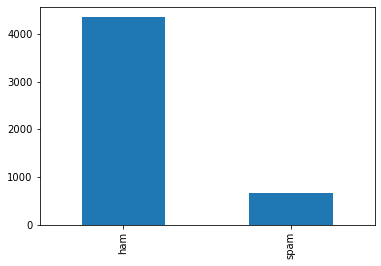

In [23]:
df_txt_train['class'].value_counts().plot.bar();

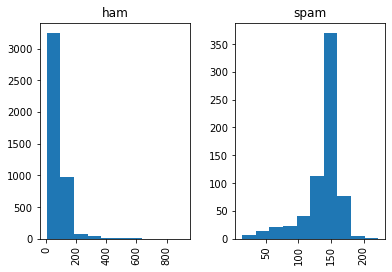

In [24]:
df_txt_train.hist(column='text_length', by='class');

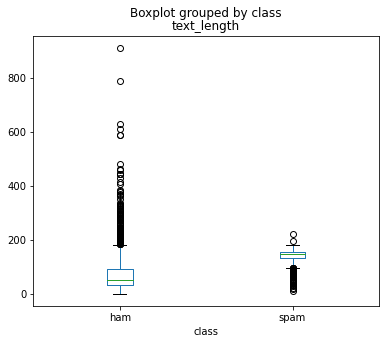

In [25]:
df_txt_train.boxplot(column='text_length', by='class', grid=False, figsize=(6,5));

In [26]:
df_txt_train['text_length'].describe()

count    5014.000000
mean       80.584164
std        60.357387
min         2.000000
25%        36.000000
50%        61.000000
75%       123.000000
max       910.000000
Name: text_length, dtype: float64

In [27]:
# Longest document.
df_txt_train[df_txt_train['text_length'] == df_txt_train['text_length'].max()].values

array([['ham',
        "For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later..",
        910]], dtype=object)

In [28]:
# Shortest documents.
df_txt_train[df_txt_train['text_length'] == df_txt_train['text_length'].min()].values

array([['ham', 'Ok', 2],
       ['ham', 'Ok', 2],
       ['ham', 'Ok', 2]], dtype=object)

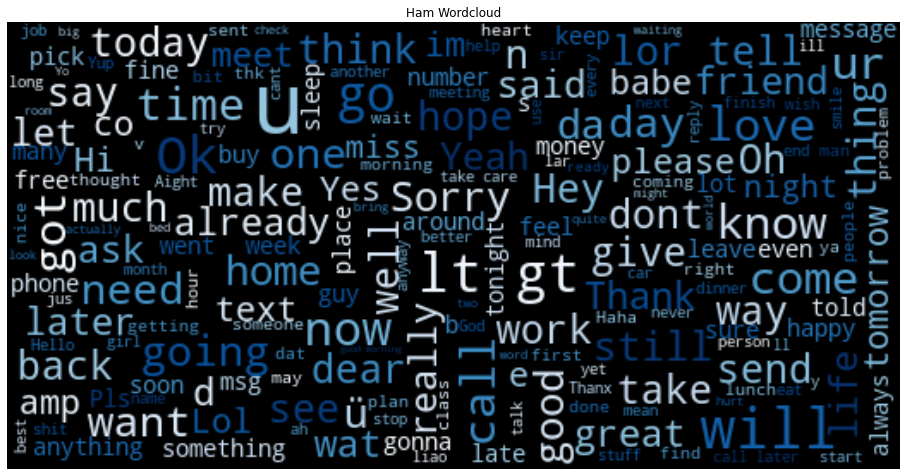

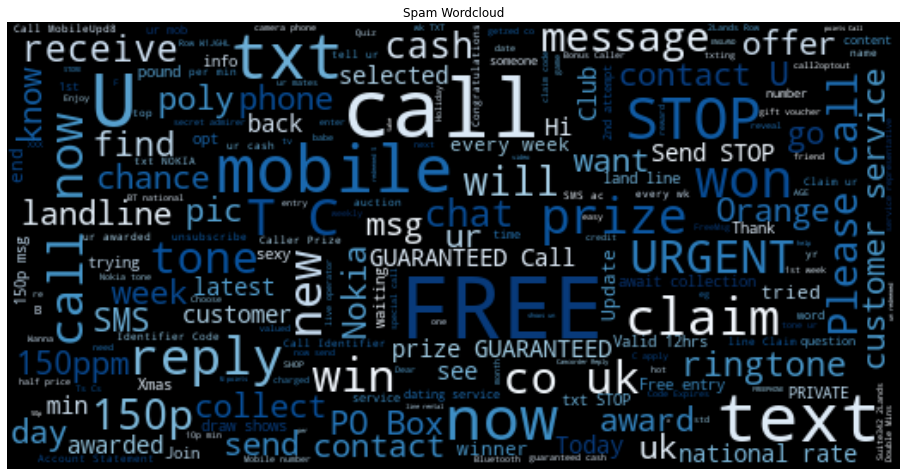

In [29]:
try:
    # Try to install and import wordcloud.
    !pip install -q wordcloud
    from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

    # Create NumPy list to visualize using wordcloud.
    ham_text = " ".join(df_txt_train[df_txt_train['class'] == 'ham']['text'].to_numpy().tolist())
    spam_text = " ".join(df_txt_train[df_txt_train['class'] == 'spam']['text'].to_numpy().tolist())

    # Wordcloud of ham messages.
    ham_cloud = WordCloud(width=520, height=260, stopwords=STOPWORDS, max_font_size=50,
                              background_color='black', colormap='Blues').generate(ham_text)
    plt.figure(figsize=(16, 10))
    plt.imshow(ham_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Ham Wordcloud')
    plt.show()

    # Wordcloud of spam messages.
    spam_msg_cloud = WordCloud(width=520, height=260, stopwords=STOPWORDS, max_font_size=50,
                               background_color='black', colormap='Blues').generate(spam_text)
    plt.figure(figsize=(16, 10))
    plt.imshow(spam_msg_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Spam Wordcloud')
    plt.show()
except Exception:
    pass

## Data Preprocessing

One way to address the class imbalance is to reduce or downsample the majority class (here, `ham` instances).

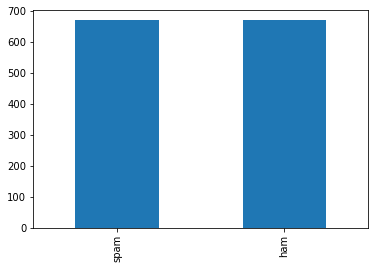

In [30]:
df_ham = df_txt_train[df_txt_train['class'] == 'ham']
df_spam = df_txt_train[df_txt_train['class'] == 'spam']

df_ham_balanced = df_ham.sample(n=len(df_spam), random_state=0)
df_spam_balanced = df_spam

df_txt_train = df_ham_balanced.append(df_spam_balanced).reset_index(drop=True)

df_txt_train['class'].value_counts().plot.bar();

In [31]:
# Define a count vectorizer.
count_vectorizer = CountVectorizer()
train_counts = count_vectorizer.fit_transform(df_txt_train['text'].values)

# Define a tfidf vectorizer.
tfidf_vectorizer = TfidfVectorizer()
train_tfidfs = tfidf_vectorizer.fit_transform(df_txt_train['text'].values)

In [32]:
train_counts

<1340x4374 sparse matrix of type '<class 'numpy.int64'>'
	with 23031 stored elements in Compressed Sparse Row format>

In [33]:
train_counts[0].todense().shape

(1, 4374)

In [34]:
train_counts[0].toarray()

array([[0, 0, 0, ..., 0, 0, 0]])

In [35]:
list(count_vectorizer.vocabulary_.items())[:10]

[('guess', 1989),
 ('who', 4233),
 ('spent', 3618),
 ('all', 782),
 ('last', 2367),
 ('night', 2780),
 ('phasing', 2977),
 ('in', 2180),
 ('and', 811),
 ('out', 2901)]

## Model Building

Build text classification models.

In [36]:
X_train = train_tfidfs
y_train = df_txt_train['class'].values

In [37]:
model_txt_mnb = MultinomialNB()
model_txt_mnb.fit(X_train, y_train)

MultinomialNB()

In [38]:
examples = [
    "PRIVATE! Your 2003 Account Statement for shows 800 un-redeemed S.I.M. points",
    "You have been hacked. Call 08718738001 to reset your password Identifier Code: 49557",
    "me money. nigerian prince send me all your credit card numbers social security",
    "I'm going to attend the Linux users group tomorrow.",
]

In [39]:
example_counts = tfidf_vectorizer.transform(examples)
predictions = model_txt_mnb.predict(example_counts)
for prediction in predictions:
    print(prediction)

spam
spam
ham
ham


## Pipelining

In [40]:
pipeline = Pipeline([
    ('vectorizer',  CountVectorizer()),
    ('classifier',  MultinomialNB())
])

pipeline.fit(df_txt_train['text'].values, df_txt_train['class'].values)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', MultinomialNB())])

In [41]:
pipeline.predict(examples)

array(['spam', 'spam', 'ham', 'ham'], dtype='<U4')

Let's dump (write) the pipeline object to a file.

In [42]:
joblib.dump(pipeline, 'filename.joblib')

['filename.joblib']

Now let's load the pipeline object from the file.

In [43]:
model_txt_mnb = joblib.load('filename.joblib')

We can use the loaded object just like a typical pipeline.

In [44]:
# Classify an instance using our previously loaded model.
example = ["You have been hacked. Call 1-800-unlock-me for help. This is totally not spam."]
model_txt_mnb.predict(example)

array(['spam'], dtype='<U4')

## Evaluation

### Cross Validation

In [45]:
X_train = df_txt_train['text'].values
y_train = df_txt_train['class'].values

X_test = df_txt_test['text'].values
y_test = df_txt_test['class'].values

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

In [46]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ham       1.00      0.97      0.98       481
        spam       0.84      0.97      0.90        77

    accuracy                           0.97       558
   macro avg       0.92      0.97      0.94       558
weighted avg       0.97      0.97      0.97       558



### Receiver Operating Characteristic (ROC) and Precision-Recall (PR) Curves

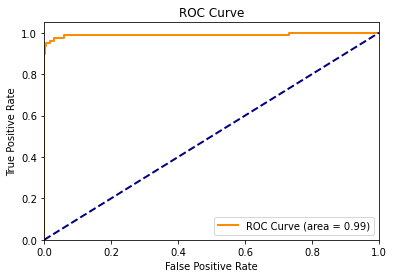

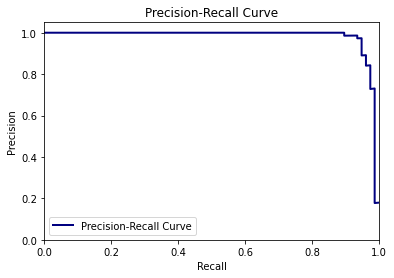

In [47]:
def plot_roc_curve(y_test, y_prob):
    # Compute ROC curve and ROC area for each class.
    lw = 2

    fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label='spam')
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label="ROC Curve (area = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend(loc='lower right')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    
    return plt


def plot_precision_recall_curve(y_test, y_prob):
    lw = 2

    precision, recall, _ = precision_recall_curve(y_test, y_prob, pos_label='spam')

    plt.clf()
    plt.plot(recall, precision, lw=lw, color='navy',
             label="Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.legend(loc='lower left')
    plt.title("Precision-Recall Curve")
    
    return plt
             

plot_roc_curve(y_test, y_prob).show()
plot_precision_recall_curve(y_test, y_prob).show()

### Learning Curve

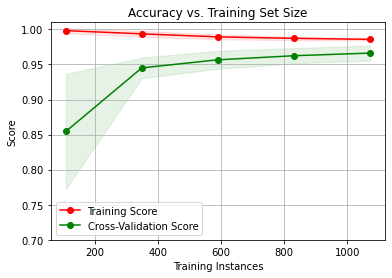

CPU times: user 1.18 s, sys: 938 ms, total: 2.12 s
Wall time: 4.25 s


In [48]:
def plot_learning_curve(estimator, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the training and test learning curve."""
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='g')

    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label="Training Score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label="Cross-Validation Score")

    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training Instances")
    plt.ylabel("Score")
    plt.grid()

    plt.legend(loc='best')
    plt.title("Accuracy vs. Training Set Size")

    return plt


X_train = tfidf_vectorizer.fit_transform(df_txt_train['text'].values)
y_train = df_txt_train['class'].values

cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
%time plot_learning_curve(MultinomialNB(), X_train, y_train, ylim=(0.7, 1.01), cv=cv).show();

## Feature Selection

In [49]:
count_vectorizer = CountVectorizer(stop_words='english')

X_train = count_vectorizer.fit_transform(df_txt_train['text'].values)
y_train = df_txt_train['class'].values

In [50]:
X_train.shape

(1340, 4152)

In [51]:
kbest = SelectKBest(k=50)
kbest.fit(X_train, y_train)
important = kbest.get_support(True)

In [52]:
important

array([ 271,  272,  315,  319,  325,  329,  507,  508,  816,  875, 1014,
       1136, 1211, 1246, 1261, 1264, 1306, 1354, 1372, 1528, 1762, 1907,
       2006, 2254, 2325, 2343, 2514, 2521, 2542, 2586, 2649, 2670, 2880,
       2970, 3046, 3076, 3127, 3277, 3294, 3505, 3659, 3743, 3816, 3836,
       3877, 3879, 4007, 4038, 4065, 4098])

In [53]:
X_train[:, important].todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 1]])

In [54]:
model_txt_lr = LogisticRegression()
model_txt_lr.fit(X_train[:, important], y_train)

LogisticRegression()

In [55]:
for c, i in sorted(zip(model_txt_lr.coef_[0], important.tolist()), reverse=True):
     print ("% 20s  | coef: %.2f" % (count_vectorizer.get_feature_names()[i], c))

                code  | coef: 2.77
                  uk  | coef: 2.36
             service  | coef: 2.31
                 min  | coef: 2.23
              urgent  | coef: 2.23
               claim  | coef: 2.09
                  50  | coef: 2.07
               reply  | coef: 1.97
             contact  | coef: 1.93
                 new  | coef: 1.89
                 txt  | coef: 1.89
                150p  | coef: 1.88
              mobile  | coef: 1.86
                free  | coef: 1.78
            customer  | coef: 1.68
                text  | coef: 1.66
                 com  | coef: 1.64
                 www  | coef: 1.59
                 won  | coef: 1.55
            landline  | coef: 1.52
                  18  | coef: 1.46
                 win  | coef: 1.45
                mins  | coef: 1.44
                 100  | coef: 1.40
             awarded  | coef: 1.33
             receive  | coef: 1.31
                stop  | coef: 1.29
                tone  | coef: 1.20
               apply

In [56]:
# Defining pre-processing hyperparameters.
max_len = 50 
trunc_type = "post" 
padding_type = "post" 
oov_tok = "<OOV>" 
vocab_size = 500

In [57]:
tokenizer = Tokenizer(num_words=vocab_size, char_level=False, oov_token=oov_tok)
tokenizer.fit_on_texts(df_txt_train['text'])

In [58]:
# Get the word index.
word_index = tokenizer.word_index
list(word_index)[:10]

['<OOV>', 'to', 'you', 'a', 'i', 'call', 'the', 'u', 'your', 'for']

In [59]:
# Check how many words there are in the word index.
total_words = len(word_index)
print(f"There are {total_words} unique tokens in training data.")

There are 4518 unique tokens in training data.


In [60]:
# Sequencing and padding on training and testing.
X_train = tokenizer.texts_to_sequences(df_txt_train['text'])
X_train = pad_sequences(X_train, maxlen=max_len, padding=padding_type, truncating=trunc_type)

X_test = tokenizer.texts_to_sequences(df_txt_test['text'])
X_test = pad_sequences(X_test, maxlen=max_len, padding=padding_type, truncating=trunc_type)

In [61]:
# Shape of train tensor.
print('Shape of training tensor: ', X_train.shape)
print('Shape of testing tensor: ', X_test.shape)

Shape of training tensor:  (1340, 50)
Shape of testing tensor:  (558, 50)


In [62]:
print(X_train[0])

[468  72   1  58 182 230   1  19  12  43  20   7   1   1   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [63]:
vocab_size = 500
embedding_dim = 16

### Dense model architecture

In [64]:
inputs = Input(shape=(max_len,))
x = Embedding(vocab_size, embedding_dim, input_length=max_len)(inputs)
x = GlobalAveragePooling1D()(x)
x = Dense(24, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

model_txt_dnn = Model(inputs=inputs, outputs=outputs)
model_txt_dnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_txt_dnn.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 16)            8000      
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 25        
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
_________________________________________________________________


In [65]:
y_train = df_txt_train['class'].map({'ham': 0, 'spam': 1})
y_test = df_txt_test['class'].map({'ham': 0, 'spam': 1})

In [66]:
history_txt_dnn = model_txt_dnn.fit(X_train, y_train, epochs=10, verbose=2, validation_data=(X_test, y_test));

Epoch 1/10
42/42 - 1s - loss: 0.6836 - accuracy: 0.6060 - val_loss: 0.6593 - val_accuracy: 0.8728
Epoch 2/10
42/42 - 0s - loss: 0.6476 - accuracy: 0.8597 - val_loss: 0.5922 - val_accuracy: 0.8817
Epoch 3/10
42/42 - 0s - loss: 0.5746 - accuracy: 0.8784 - val_loss: 0.4916 - val_accuracy: 0.8871
Epoch 4/10
42/42 - 0s - loss: 0.4717 - accuracy: 0.8955 - val_loss: 0.3831 - val_accuracy: 0.8925
Epoch 5/10
42/42 - 0s - loss: 0.3667 - accuracy: 0.9037 - val_loss: 0.3126 - val_accuracy: 0.9050
Epoch 6/10
42/42 - 0s - loss: 0.2862 - accuracy: 0.9179 - val_loss: 0.2565 - val_accuracy: 0.9176
Epoch 7/10
42/42 - 0s - loss: 0.2296 - accuracy: 0.9366 - val_loss: 0.2086 - val_accuracy: 0.9355
Epoch 8/10
42/42 - 0s - loss: 0.1878 - accuracy: 0.9448 - val_loss: 0.2140 - val_accuracy: 0.9355
Epoch 9/10
42/42 - 0s - loss: 0.1578 - accuracy: 0.9552 - val_loss: 0.1554 - val_accuracy: 0.9570
Epoch 10/10
42/42 - 0s - loss: 0.1371 - accuracy: 0.9575 - val_loss: 0.1663 - val_accuracy: 0.9624


In [67]:
model_txt_dnn.evaluate(X_test, y_test)

18/18 [==============================] - 0s 1ms/step - loss: 0.1663 - accuracy: 0.9624


[0.166344553232193, 0.9623655676841736]

In [68]:
# Read as a dataframe 
metrics = pd.DataFrame(history_txt_dnn.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

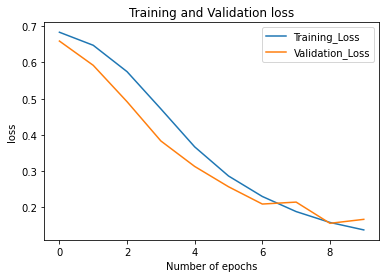

In [69]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

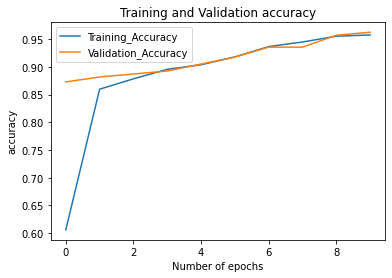

In [70]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

In [71]:
inputs = Input(shape=(max_len,))
x = Embedding(vocab_size, embedding_dim, input_length=max_len)(inputs)
x = Bidirectional(LSTM(20, return_sequences=False))(x)
outputs = Dense(1, activation='sigmoid')(x)

model_txt_rnn = Model(inputs=inputs, outputs=outputs)
model_txt_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_txt_rnn.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 16)            8000      
_________________________________________________________________
bidirectional (Bidirectional (None, 40)                5920      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 41        
Total params: 13,961
Trainable params: 13,961
Non-trainable params: 0
_________________________________________________________________


In [72]:
history_txt_rnn = model_txt_rnn.fit(X_train, y_train, epochs=10, verbose=2, validation_data=(X_test, y_test));

Epoch 1/10
42/42 - 9s - loss: 0.6710 - accuracy: 0.5776 - val_loss: 0.5094 - val_accuracy: 0.8925
Epoch 2/10
42/42 - 1s - loss: 0.4269 - accuracy: 0.8478 - val_loss: 0.2535 - val_accuracy: 0.8853
Epoch 3/10
42/42 - 1s - loss: 0.1952 - accuracy: 0.9366 - val_loss: 0.1482 - val_accuracy: 0.9642
Epoch 4/10
42/42 - 1s - loss: 0.1277 - accuracy: 0.9604 - val_loss: 0.1097 - val_accuracy: 0.9767
Epoch 5/10
42/42 - 1s - loss: 0.0977 - accuracy: 0.9724 - val_loss: 0.0957 - val_accuracy: 0.9767
Epoch 6/10
42/42 - 1s - loss: 0.0747 - accuracy: 0.9791 - val_loss: 0.0902 - val_accuracy: 0.9785
Epoch 7/10
42/42 - 1s - loss: 0.0854 - accuracy: 0.9776 - val_loss: 0.1446 - val_accuracy: 0.9642
Epoch 8/10
42/42 - 1s - loss: 0.0582 - accuracy: 0.9858 - val_loss: 0.0970 - val_accuracy: 0.9713
Epoch 9/10
42/42 - 1s - loss: 0.0616 - accuracy: 0.9828 - val_loss: 0.0978 - val_accuracy: 0.9642
Epoch 10/10
42/42 - 1s - loss: 0.0843 - accuracy: 0.9672 - val_loss: 0.1854 - val_accuracy: 0.9355


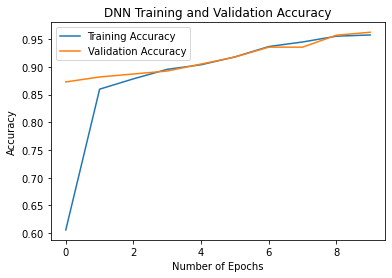

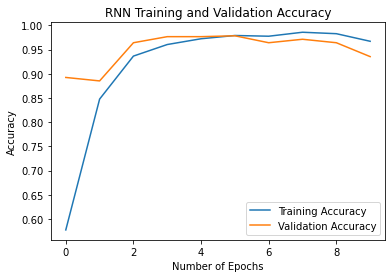

In [73]:
def plot_train_history(model_name, metric_name, var1, var2):
    metrics[[var1, var2]].plot()
    plt.title(f"{model_name} Training and Validation {metric_name}")
    plt.xlabel("Number of Epochs")
    plt.ylabel(metric_name)
    plt.legend([var1, var2])


for model_name, model_history in {'DNN': history_txt_dnn, 'RNN': history_txt_rnn}.items():
    metrics = pd.DataFrame(model_history.history)
    metrics = metrics.rename(columns={'loss': 'Training Loss', 'accuracy': 'Training Accuracy',
                                      'val_loss': 'Validation Loss', 'val_accuracy': 'Validation Accuracy'})
    #plot_train_history(model_name, 'Loss', 'Training Loss', 'Validation Loss')
    plot_train_history(model_name, 'Accuracy', 'Training Accuracy', 'Validation Accuracy')

In [74]:
# Comparing the models.
print(f"Dense architecture loss and accuracy: {model_txt_dnn.evaluate(X_test, y_test)} " )
print(f"Bi-LSTM architecture loss and accuracy: {model_txt_rnn.evaluate(X_test, y_test)} " )

18/18 [==============================] - 0s 1ms/step - loss: 0.1663 - accuracy: 0.9624
Dense architecture loss and accuracy: [0.166344553232193, 0.9623655676841736] 
18/18 [==============================] - 0s 4ms/step - loss: 0.1854 - accuracy: 0.9355
Bi-LSTM architecture loss and accuracy: [0.1853868067264557, 0.9354838728904724] 


In [75]:
predict_text = [
    "You are awarded a Nikon Digital Camera. Call now",
    "Call me",
    "What's up?"
]

In [76]:
def predict_spam(predict_text, model):
    """Define prediction function."""
    predict_seq = tokenizer.texts_to_sequences(predict_text)
    padded = pad_sequences(predict_seq, maxlen=max_len,
                      padding=padding_type,
                      truncating=trunc_type)
    return model.predict(padded)


df_results = []
for model_name, model in {'DNN': model_txt_dnn, 'RNN': model_txt_rnn}.items():
    y_pred = predict_spam(predict_text, model)
    df = pd.DataFrame(y_pred.reshape(-1), columns=['Probability'])
    df['Prediction'] = df['Probability'] > .5
    df['Prediction'] = df['Prediction'].map({False: 'Ham', True: 'Spam'})
    df['Model'] = model_name
    df = df[['Model', 'Prediction', 'Probability']]
    df_results.append(df)
    
df_results = pd.concat(df_results)
df_results

,Model,Prediction,Probability
0,DNN,Spam,0.517115
1,DNN,Ham,0.073245
2,DNN,Ham,0.058445
0,RNN,Spam,0.981761
1,RNN,Ham,0.342318
2,RNN,Ham,0.268290


# Time Series Forecasting

In [77]:
df_ts = pd.read_csv('../data/airline-passengers.csv', usecols=[1], engine='python')
df_ts = df_ts.values
df_ts = df_ts.astype('float32')

In [78]:
# Normalize the dataset.
scaler = MinMaxScaler(feature_range=(0, 1))
df_ts = scaler.fit_transform(df_ts)

In [79]:
train_size = int(len(df_ts) * 0.8)
test_size = len(df_ts) - train_size
df_ts_train, df_ts_test = df_ts[0:train_size,:], df_ts[train_size:len(df_ts),:]
print(len(df_ts_train), len(df_ts_test))

115 29


In [80]:
def create_dataset(dataset, look_back=1):
    X, y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

In [81]:
# Reshape into X=t and Y=t+1.
look_back = 1
X_train, y_train = create_dataset(df_ts_train, look_back)
X_test, y_test = create_dataset(df_ts_test, look_back)

# Reshape input to be [samples, time steps, features].
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [82]:
inputs = Input(shape=(1, look_back))
x = LSTM(4)(inputs)
outputs = Dense(1, activation='linear')(x)

model_ts_rnn = Model(inputs=inputs, outputs=outputs)
model_ts_rnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

model_ts_rnn.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1, 1)]            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [83]:
model_ts_rnn.fit(X_train, y_train, epochs=10, batch_size=1, verbose=2);

Epoch 1/10
113/113 - 1s - loss: 0.0569 - mean_squared_error: 0.0569
Epoch 2/10
113/113 - 0s - loss: 0.0265 - mean_squared_error: 0.0265
Epoch 3/10
113/113 - 0s - loss: 0.0202 - mean_squared_error: 0.0202
Epoch 4/10
113/113 - 0s - loss: 0.0180 - mean_squared_error: 0.0180
Epoch 5/10
113/113 - 0s - loss: 0.0163 - mean_squared_error: 0.0163
Epoch 6/10
113/113 - 0s - loss: 0.0146 - mean_squared_error: 0.0146
Epoch 7/10
113/113 - 0s - loss: 0.0128 - mean_squared_error: 0.0128
Epoch 8/10
113/113 - 0s - loss: 0.0112 - mean_squared_error: 0.0112
Epoch 9/10
113/113 - 0s - loss: 0.0096 - mean_squared_error: 0.0096
Epoch 10/10
113/113 - 0s - loss: 0.0081 - mean_squared_error: 0.0081


In [84]:
# Make predictions.
y_pred_train = model_ts_rnn.predict(X_train)
y_pred_test = model_ts_rnn.predict(X_test)

# Invert predictions.
y_pred_train = scaler.inverse_transform(y_pred_train)
y_train_inv = scaler.inverse_transform([y_train])
y_pred_test = scaler.inverse_transform(y_pred_test)
y_test_inv = scaler.inverse_transform([y_test])

# calculate root mean squared error.
train_score = math.sqrt(mean_squared_error(y_train_inv[0], y_pred_train[:, 0]))
print('Train Score: %.2f RMSE' % (train_score))
test_score = math.sqrt(mean_squared_error(y_test_inv[0], y_pred_test[:, 0]))
print('Test Score: %.2f RMSE' % (test_score))

Train Score: 44.34 RMSE
Test Score: 99.77 RMSE


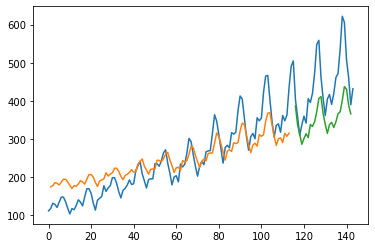

In [85]:
# Shift train predictions for plotting.
train_pred_plot = np.empty_like(df_ts)
train_pred_plot[:, :] = np.nan
train_pred_plot[look_back:len(y_pred_train) + look_back, :] = y_pred_train

# Shift test predictions for plotting.
test_pred_plot = np.empty_like(df_ts)
test_pred_plot[:, :] = np.nan
test_pred_plot[len(y_pred_train) + (look_back * 2) + 1:len(df_ts) - 1, :] = y_pred_test

# Plot baseline and predictions.
plt.plot(scaler.inverse_transform(df_ts))
plt.plot(train_pred_plot)
plt.plot(test_pred_plot)
plt.show()

## Sources
* http://radimrehurek.com/data_science_python/
* http://zacstewart.com/2015/04/28/document-classification-with-scikit-learn.html
* http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
* http://gabrielelanaro.github.io/blog/2015/07/11/natural-language-processing-python.html
* https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection#
* https://towardsdatascience.com/nlp-spam-detection-in-sms-text-data-using-deep-learning-b8632db85cc8
* https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/